In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df

# Except subjects for predictors :
problematic_subjects_misc = ["611d60c383f4f70ff4bc99fd", # S2 : Did the task twice 
                             "66a74bdfdcaccdc0703894d5", # Subjects with consent revoked 
                            "667d92f2ea5c1542f417285d",
                            "6548f570022275786186ffbd"]

# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "003"
# Study 2 : the std of the was 0.025,0.1 and 0.175
PROLIFIC_STUDY_IDs = ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"]

TASK_RESULTS_ALL = []
for prolific_study_id in PROLIFIC_STUDY_IDs:
    task_results = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,prolific_study_id,
                                                              process_feedback_data_stream=True,override_save=False)
    print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
    TASK_RESULTS_ALL += task_results
print("Total : {} subjects".format(len(TASK_RESULTS_ALL)))

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")

 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.


In [2]:
# The initial datframe is the first tuple in our task result list of tuples : 
subjects_df = pd.DataFrame([entry[0] for entry in TASK_RESULTS])

# Avoid too many categories : 
subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

category_counts = subjects_df['Nationality'].value_counts()
threshold = 2
subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

# There was a single noise term for the whole training for each subject : 
subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in TASK_RESULTS]

# We add it to the df : 
subjects_df["feedback_noise_std"] = subject_noise_parameters

# # Create a pandas dataframe from the list of subject dictionnaries :

# In this dataframe, we're interested in sotring various kinds of data from the trials : 
# 1/ Data from the instruction phase

# 2/ Data from the feedback gauge :
# Timestep values :
all_subject_scores = [subjdata[2]["scoring"] for subjdata in TASK_RESULTS]
subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
# Real time gauge values :
subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in TASK_RESULTS] # Each element is a list of list os arrays (with varying shape)

# 3/ Data from the hidden grid :
# The grid for a specific trial: 
trial_grids = [entry[2]["process"]["grids"] for entry in TASK_RESULTS]
subjects_df["grid_layout"] = trial_grids
# Position value :
subject_positions = [entry[2]["process"]["positions"] for entry in TASK_RESULTS]
subjects_df["subject_positions"] = subject_positions

goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in TASK_RESULTS]
subjects_df["goal_position"] = goal_positions

def euclidian_distance(position,goal):
    return jnp.linalg.norm(position-goal,2)
gs = trial_grids[0][0].shape
maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


# 4/ Data from the realized actions :

# Actions performed : this encompasses the points dropped
# But may also include temporal elements such as :
# - the time taken to perform an actions (first point / second point)
# - when the action was performed with regard to the gauge
canvas_size = TASK_RESULTS[0][0]["canvas_size"] # Constant across all subjects + conditions
all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in TASK_RESULTS]).astype(float)

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
# print(all_actions_data)
# Normalize the point data :
all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


# First, let's get a mask for all actions that were NOT performed :
mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
both_points_only = (mask[...,0] & mask[...,1])
     # All points where at least one value is missing

Nactions = all_actions_data[...,0,0].size
Nmissed_actions = (~both_points_only).sum()
print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

subjects_df["raw_points"] = list(all_actions_data)


# Encoded barycenters :
barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
subjects_df["action_barycenters"] = list(barycenters)

# Encoded euclidian distance between points :
action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
subjects_df["action_distances"] = list(action_distances)

# Encoded evolution of point angles :
angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
subjects_df["action_angles"] = list(angles)

# Encoded delays between stimuli, point1 and point2 :
all_action_delays = all_actions_data[...,-1,2]
unfit_actions = (all_action_delays<10)
subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

# Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
last_k_trials,last_t_timesteps = 3,5
all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


# And for the blind trial :
blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()

A total of 33/15950 actions were missed. (0.21 %)


In [3]:

# If the points were too close, no angle was recorded :
# The limit was arbitrrarily chosen at 7.5 :
min_dist_norm = 7.5/(np.sqrt(2)*750)

preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : 10,
        "observation_ends_at_point" : 2
    }
}
    # We can modify these at will
from analysis_tools.preprocess import get_preprocessed_data_from_df

data = get_preprocessed_data_from_df(subjects_df,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default")

Out of the 15950.0 actions performed by our subjects, 15917.0 were 'valid' (99.8 %)
Out of the 15950.0 feedback sequences potentially observed by our subjects, 15950 were 'valid' (100.0 %)


In [4]:

print(data["observations"]["deltas"].shape)

print(data["observations"]["vect"][0].shape)

print(data["observations"]["vect"][1].shape)

print(data["actions"]["vect"])

(145, 10, 11)
(145, 10, 11, 10)
(145, 10, 11, 10)
{'position': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,

In [14]:


from simulate.compute_likelihood import fit_map_agent,compute_loglikelihood
from agents import rescorla_wagner_agent,random_agent
from functools import partial
import tensorflow_probability.substrates.jax.distributions as tfd
import jax.random as jr
from jax import vmap


# Distance actions
Nsteps = 500
action_dim = "angle"

formatted_stimuli= [data["observations"]["vect"][1]]
bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
rewards = jnp.array(data["observations"]["deltas"])
actions = jnp.array(data["actions"]["vect"][action_dim])[:,:-1,:,:] # Ignore the last trial

Nsubj,Ntrials,Nactions,_ = actions.shape
timesteps = jnp.broadcast_to(jnp.arange(Nactions+1),(Nsubj,Ntrials,Nactions+1))

data_all_subjects = (formatted_stimuli,bool_stimuli,rewards,actions,timesteps)

print(rewards)


Nsubj,Ntrials,Nactions,Ncategories = actions.shape
static_params = (Ncategories,)
agent = partial(rescorla_wagner_agent,constants=static_params)
rng_agent = partial(random_agent,constants=static_params)

param_priors = (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(10.0,5.0))
_,_,_,_,_,encoder = agent(None)

def fit_agent(_data_one_subject,_seed):   
    # Multi-iteration based MAP : (we randomize the initial point and try to find minimas)
    opt_vectors,(_,loss_history,param_history),encoding_function = fit_map_agent(_data_one_subject,agent,2,
                                                            param_priors,
                                                            jr.PRNGKey(_seed),
                                                            true_hyperparams=None,                          
                                                            num_steps=Nsteps,n_iter=30,initial_window=[-10,10])
    
    # We then compute the log-likelihoods of each solution for model comparison purposes :
    lls =   vmap(lambda x : compute_loglikelihood(_data_one_subject,agent(encoding_function(x)),'sum'))(opt_vectors)
    lls_rng = compute_loglikelihood(_data_one_subject,rng_agent(None),'sum') # should always be -log(Nactions)   
            
    return loss_history,opt_vectors,lls,lls_rng



fit_one_subj = partial(fit_agent,_seed=0)
loss_histories,params,lls,lls_random = vmap(fit_one_subj)(data_all_subjects)

[[[ 0.145  0.133 -0.214 ...  0.229 -0.111 -0.147]
  [ 0.     0.138  0.085 ... -0.004 -0.114  0.096]
  [ 0.     0.107 -0.126 ...  0.301  0.042  0.118]
  ...
  [ 0.     0.274  0.13  ... -0.015 -0.146  0.161]
  [ 0.     0.079  0.133 ...  0.     0.    -0.086]
  [ 0.     0.185  0.175 ... -0.024  0.024  0.   ]]

 [[ 0.107  0.048 -0.023 ... -0.068  0.216 -0.107]
  [ 0.    -0.017  0.077 ...  0.086 -0.139  0.075]
  [ 0.    -0.231  0.379 ... -0.222  0.237  0.094]
  ...
  [ 0.    -0.221  0.174 ...  0.197  0.06   0.058]
  [ 0.     0.252  0.206 ... -0.157 -0.139  0.115]
  [ 0.     0.019  0.01  ... -0.212 -0.078  0.363]]

 [[ 0.137  0.107  0.263 ... -0.102 -0.072 -0.139]
  [ 0.    -0.227  0.122 ...  0.045 -0.005  0.145]
  [ 0.     0.016  0.107 ... -0.169  0.101  0.07 ]
  ...
  [ 0.    -0.08   0.293 ... -0.083 -0.032  0.032]
  [ 0.     0.146  0.153 ... -0.001 -0.091 -0.025]
  [ 0.    -0.318 -0.046 ...  0.     0.229 -0.105]]

 ...

 [[ 0.232  0.115 -0.237 ...  0.362  0.16   0.04 ]
  [ 0.     0.217  0.

[-191.97968 -191.97972 -191.97972 -191.97972 -191.97972 -191.97978
 -191.97968 -191.97972 -191.97972 -191.97972 -191.97974 -191.97974
 -191.97974 -191.97977 -191.97972 -191.97968 -191.97972 -191.9797
 -191.97977 -191.98012 -191.97975 -191.97972 -191.97972 -191.97972
 -191.97995 -191.97972 -191.97995 -191.97981 -191.97983 -191.97978]
[0.16634353 0.16634297 0.16634291 0.1663428  0.16634294 0.16634569
 0.16634358 0.16634293 0.16634397 0.16634272 0.16634741 0.16634503
 0.16634758 0.16634555 0.16634287 0.1663435  0.16634315 0.16634338
 0.16634868 0.1664002  0.16634643 0.16634284 0.16634288 0.16634293
 0.16637334 0.16634291 0.16637753 0.16635591 0.16635768 0.16635463]
-207.94414
(145, 500, 30)


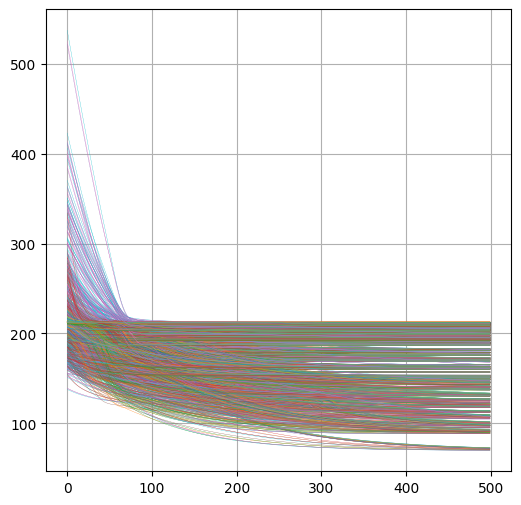

In [6]:
lrs,asts = vmap(vmap(encoder))(params)

print(lls[1])
print(lrs[1])
print(lls_random[1])

print(loss_histories.shape)
fig,ax = plt.subplots(figsize=(6,6))
ax.grid()
for subj_loss_hist in loss_histories:
    ax.plot(subj_loss_hist,lw=0.2)

Nice, let's generalize this pipeline to a wide array of proposal models, for each action modality !

In [7]:
from agents import choice_kernel_agent,random_agent,rescorla_wagner_agent,rw_ck_agent,q_learning_agent,active_inference_basic_1D

Nsubj,Ntrials,Nactions,Ncategories = actions.shape
static_params = (Ncategories,)
rng_agent = partial(random_agent,constants=static_params)


# Preprocess the data according to the xanted hyperparameters :
n_bins_feedback = 10
n_bins_action_angle = 8
n_bins_action_position_per_dim = 3

# If the points were too close, no angle was recorded :
# The limit was arbitrrarily chosen at 7.5 :
min_dist_norm = 7.5/(np.sqrt(2)*750)
preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : n_bins_action_angle,
        "position_N_bins_per_dim" : n_bins_action_position_per_dim
    },
    "observations":{
        "N_bins" : n_bins_feedback,
        "observation_ends_at_point" : 2
    }
}
data = get_preprocessed_data_from_df(subjects_df,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default")



def get_models_from_options(_Nactions,_Nbins_feedback):
    
    aif_th = 2  # Temporal horizon, big values will cause ballooning 
            # compilation times
    Ns_latent = 5 # How many latent state in the subject model ?

    aif_1D_static_params = {
        # General environment : 
        "N_feedback_ticks":_Nbins_feedback,
        # Latent state space structure
        "Ns_latent":Ns_latent,      # For 1D
        # Action discretization:
        "N_actions" : _Nactions,
        
        "Th" : aif_th
    }

    # Let's assume the following priors regarding the general models of the subjects : 
    # Overall uniform, with the following (weakly) informed priors :
    # - high reward seeking
    # - high action selection (inverse) temperature
    # - low initial action concentration and stickiness (we focus only on the learning rate here)
    # - high initial perception concentration
    aif_1D_priors = {
        # ----------------------------------------------------------------------------------------------------
        # Model parameters : these should interact with the model components in a differentiable manner
        "transition_concentration": tfd.Normal(1.0,0.5), # Initial concentrations should be rather low
        "transition_stickiness": tfd.Normal(1.0,0.5),
        "transition_learning_rate" : tfd.Uniform(low=-0.01,high=1000.0),
        "state_interpolation_temperature" : tfd.Uniform(low=-0.01,high=10000.0),
        
        "initial_state_concentration": tfd.Uniform(low=-0.01,high=1000.0),
        
        "feedback_expected_std" : tfd.Uniform(low=-0.0,high=1000.0),
        "emission_concentration" : tfd.Uniform(low=-0.01,high=1000.0),
        "emission_stickiness" :  tfd.Normal(100.0,10.0),
        
        "reward_seeking" :tfd.Normal(10.0,10.0),
        
        "action_selection_temperature" : tfd.Normal(10.0,5.0),
    }
    
    
    
    comparison_index = {
        "random":{
            "model" : partial(random_agent,constants=(_Nactions,)),
            "priors": None
        },
        "rw":{
            "model" : partial(rescorla_wagner_agent,constants=(_Nactions,)),
            "priors" : (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(10.0,5.0))
        },
        "ck":{
            "model" : partial(choice_kernel_agent,constants=(_Nactions,)),
            "priors" : (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(10.0,5.0))
        },
        "rw_ck":{
            "model":partial(rw_ck_agent,constants=(_Nactions,)),
            "priors": (tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,10.0),tfd.Uniform(low=0.0,high=1.0),tfd.Normal(5.0,10.0))
        },
        "naive_qlearning":{
            "model":partial(q_learning_agent,constants=(_Nactions,_Nbins_feedback)),
            "priors":(tfd.Uniform(low=0.0,high=1.0),tfd.Uniform(low=0.0,high=1.0),tfd.Normal(10.0,5.0),tfd.Uniform(low=0.0,high=1.0),tfd.Normal(10.0,5.0))
        },
        # "aif_1d":{
        #     "model":partial(active_inference_basic_1D,constants=aif_1D_static_params),
        #     "priors":aif_1D_priors
        # }
    }
    
    return comparison_index

Out of the 15950.0 actions performed by our subjects, 15917.0 were 'valid' (99.8 %)
Out of the 15950.0 feedback sequences potentially observed by our subjects, 15950 were 'valid' (100.0 %)


In [8]:
def compare_models(action_modality,rngkey,
                   Nsteps=100,Nheads=20,head_init_window=[-10,10]):
    results_dict = {}
    
    # The data to invert :
    formatted_stimuli= [data["observations"]["vect"][1]]
    bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
    rewards = jnp.array(data["observations"]["deltas"])
    actions = jnp.array(data["actions"]["vect"][action_modality])[:,:-1,:,:] # Ignore the last trial
    Nsubj,Ntrials,Nactions,N_categories = actions.shape
    timesteps = jnp.broadcast_to(jnp.arange(Nactions+1),(Nsubj,Ntrials,Nactions+1))
    data_all_subjects = (formatted_stimuli,bool_stimuli,rewards,actions,timesteps)


    model_index_for_action_modality = get_models_from_options(N_categories,n_bins_feedback)
    for agent_name, agent_contents in model_index_for_action_modality.items():
        print("     -> Agent : {}".format(agent_name))
        
        agent = agent_contents["model"]
        agent_priors = agent_contents["priors"]
        
        # Agent functions
        _,_,_,_,_,encoder = agent(None)
        def fit_agent(_data_one_subject,_fit_rng_key):  
            
            
            
            if agent_priors is None:
                n_params = 0
                
                _loss_history = None
                _opt_vectors = None
                
                # We then compute the log-likelihoods of each solution for model comparison purposes :
                _lls =  jnp.expand_dims(compute_loglikelihood(_data_one_subject,agent(None),'sum'),-1)
                
            else :
                n_params = len(agent_priors)
                
                # Multi-iteration based MAP : (we randomize the initial point and try to find minimas)
                _opt_vectors,(_,_loss_history,_param_history),_encoding_function = fit_map_agent(_data_one_subject,agent,
                                                                        n_params,agent_priors,
                                                                        _fit_rng_key,
                                                                        true_hyperparams=None,                          
                                                                        num_steps=Nsteps,n_iter=Nheads,initial_window=head_init_window)
                
                # We then compute the log-likelihoods of each solution for model comparison purposes :
                _lls =   vmap(lambda x : compute_loglikelihood(_data_one_subject,agent(_encoding_function(x)),'sum'))(_opt_vectors)
                    
            return _loss_history,_opt_vectors,_lls

        rngkey,local_key = jr.split(rngkey)
        
        fit_one_subj = partial(fit_agent,_fit_rng_key=local_key)
        loss_histories,best_params,lls = vmap(fit_one_subj)(data_all_subjects)

        results_dict[agent_name] = {
            "losses_hist" : loss_histories,
            "params" : best_params,
            "logliks" : lls,
            "encoder" : encoder
        }
    return results_dict


In [9]:

fitting_procedure_key = jr.PRNGKey(10)

results_dict = compare_models("angle",fitting_procedure_key,
                   Nsteps=300,Nheads=50,head_init_window=[-10,10])

     -> Agent : random
     -> Agent : rw
     -> Agent : ck
     -> Agent : rw_ck
     -> Agent : naive_qlearning


random
rw
ck
rw_ck
naive_qlearning


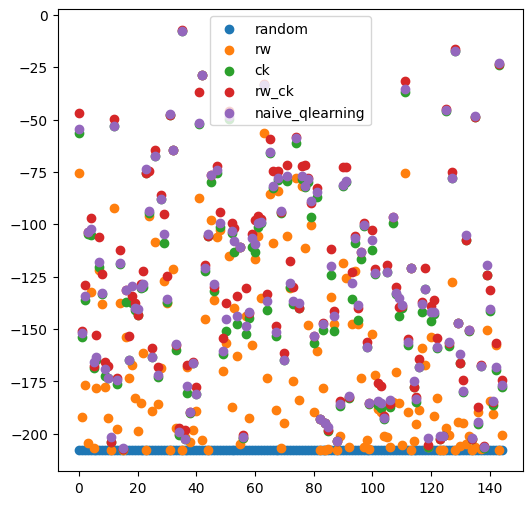

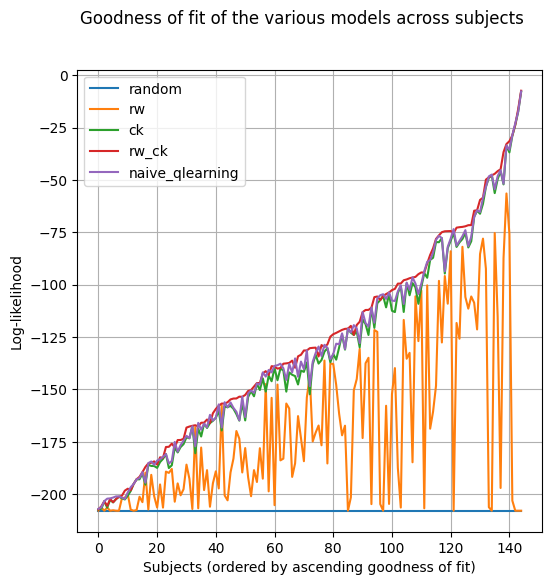

In [10]:
# print(jnp.min(dict["aif_1d"]["logliks"],axis=1))#-jnp.max(dict["naive_qlearning"]["logliks"],axis=1))

# dict["random"]["logliks"] = jnp.expand_dims()
fig,ax = plt.subplots(figsize=(6,6))
for model,results in results_dict.items():
    print(model)
    best_fits = (jnp.max(results["logliks"],axis=-1))
    
    Nsubj = best_fits.shape[0]
    ax.scatter(np.arange(Nsubj),best_fits,label = model)
ax.legend()


# Table of all results : 
model_fit_table = np.stack([np.max(r["logliks"],-1) for r in results_dict.values()])
# print(model_fit_table)

# The most likely first
indices = np.argsort(np.max(model_fit_table,0))

ordered_table = (model_fit_table[:,indices])
Nsubj = ordered_table.shape[-1]
fig,ax = plt.subplots(figsize=(6,6))
fig.suptitle("Goodness of fit of the various models across subjects")
for k,(model,results) in enumerate(results_dict.items()):
    ax.plot(np.arange(Nsubj),ordered_table[k,:],label = model)
ax.set_ylabel("Log-likelihood")
ax.set_xlabel("Subjects (ordered by ascending goodness of fit)")
ax.legend()
ax.grid()

Overall, the rw-ck model seems to fit the data the best ! We may try to improve the fitness of some of these models even further by adding additionnal variables, but one thing we could do is see how a change in the experimental paradigm may help us distinguish between these models a little bit better !

For now, let's plot the winning parameters for the RW-CK model :

(145, 50, 4)
[[2.07586929e-01 1.82578459e-01 2.83693969e-01 ... 1.96068957e-01
  2.04092845e-01 2.70828187e-01]
 [4.09257203e-01 4.13722694e-01 4.00865406e-01 ... 4.01931882e-01
  4.01946872e-01 4.01931494e-01]
 [8.32549095e-01 8.32545042e-01 8.28878760e-01 ... 8.32548082e-01
  8.29168141e-01 8.31456423e-01]
 ...
 [3.29902500e-01 2.39946902e-01 1.65060326e-01 ... 1.69198319e-01
  1.48795322e-01 1.76170781e-01]
 [2.80078948e-01 1.50539979e-01 2.02046431e-05 ... 1.18651216e-04
  2.14898046e-05 2.92861369e-03]
 [1.27584428e-01 3.69731486e-02 3.96241099e-02 ... 3.78034078e-02
  3.78813706e-02 3.88564989e-02]]
[[15.544758  18.236832  10.760259  ... 16.686146  16.050009  11.383632 ]
 [ 4.814923   4.783359   4.902319  ...  4.8923445  4.892258   4.892359 ]
 [ 4.716114   4.716095   4.7388387 ...  4.716119   4.733044   4.722063 ]
 ...
 [ 6.081167   8.121537  11.796285  ... 11.489477  13.152691  11.042285 ]
 [ 2.7353325  6.5965614  5.000049  ...  5.000314   5.000056   4.982837 ]
 [ 2.543969  10.2

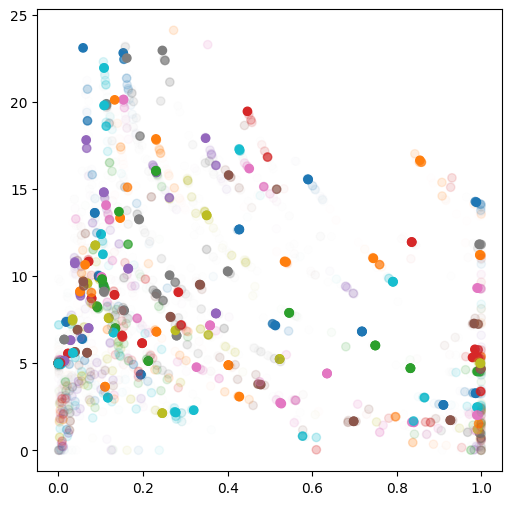

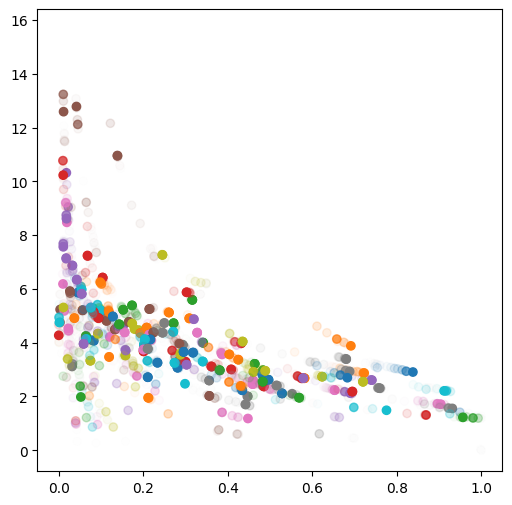

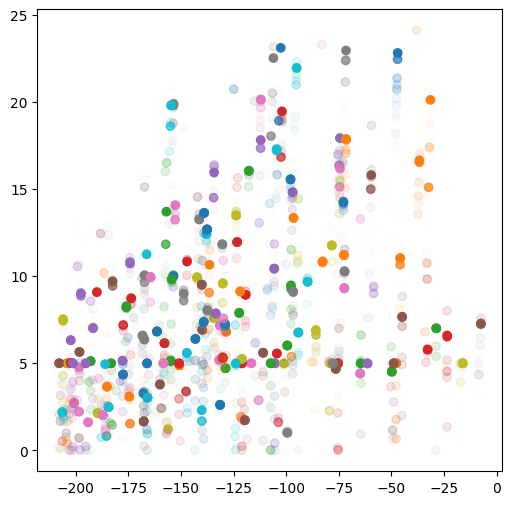

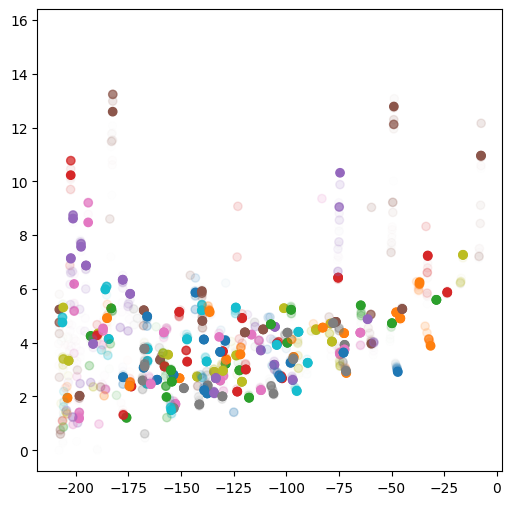

In [11]:
import jax

# Table of all results : 
model_fit_table = results_dict["rw_ck"]["logliks"]
model_fit_params = results_dict["rw_ck"]["params"]
rw_ck_encoder =  results_dict["rw_ck"]["encoder"]

filter_out_low_likelihoods =  jax.nn.softmax(5.0*model_fit_table,axis=-1)
head_filters = filter_out_low_likelihoods/jnp.max(filter_out_low_likelihoods,axis=-1,keepdims=True)
head_filters = np.array(head_filters)

print(model_fit_params.shape)

alpha,beta,alpha_ck,beta_ck = (vmap(vmap(rw_ck_encoder))(model_fit_params))
print(alpha)
print(beta)

fig,ax = plt.subplots(figsize=(6,6))
for subj in range(alpha.shape[0]):
    ax.scatter(alpha[subj],beta[subj],alpha=head_filters)
    
fig,ax = plt.subplots(figsize=(6,6))
for subj in range(alpha.shape[0]):
    ax.scatter(alpha_ck[subj],beta_ck[subj],alpha=head_filters)
    
fig,ax = plt.subplots(figsize=(6,6))
for subj in range(alpha.shape[0]):
    ax.scatter(model_fit_table[subj],beta[subj],alpha=head_filters)
    
fig,ax = plt.subplots(figsize=(6,6))
for subj in range(alpha.shape[0]):
    ax.scatter(model_fit_table[subj],beta_ck[subj],alpha=head_filters)

final_perf             float64
noise_std              float64
rw_ck_alpha             object
rw_ck_beta              object
rw_ck_alpha_ck          object
rw_ck_beta_ck           object
rw_ck_logliks           object
rw_ck_logliks_alpha     object
dtype: object


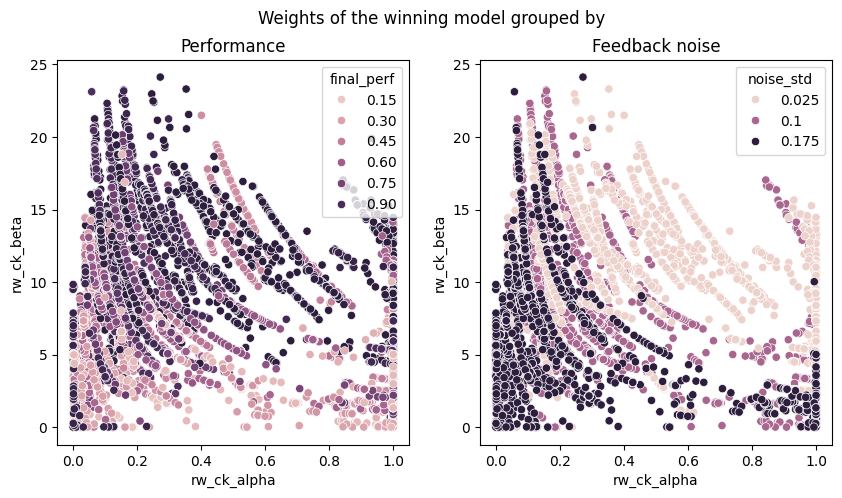

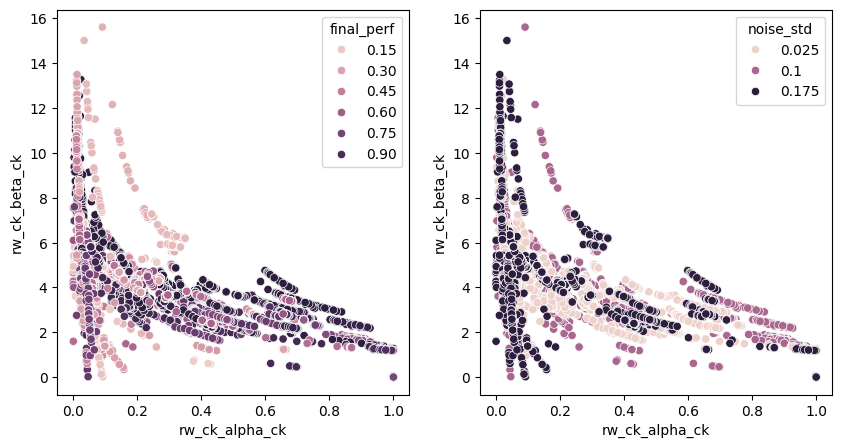

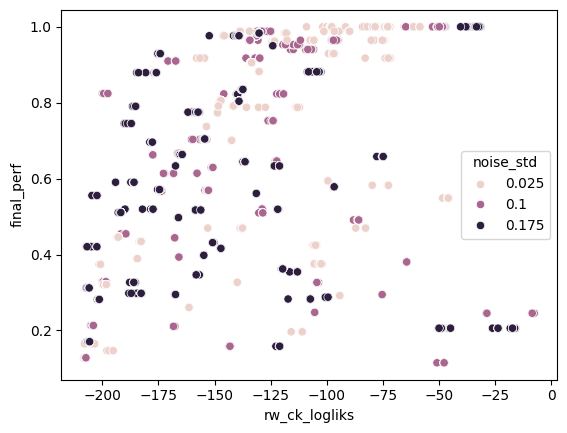

In [ ]:
plot_df = pd.DataFrame()
plot_df["final_perf"] = list(np.array(subjects_df["final_performance"]))
plot_df["noise_std"] = subjects_df["feedback_noise_std"]
plot_df["rw_ck_alpha"] = np.reshape(alpha,(Nsubj,-1)).tolist()
plot_df["rw_ck_beta"] = np.reshape(beta,(Nsubj,-1)).tolist()
plot_df["rw_ck_alpha_ck"] = np.reshape(alpha_ck,(Nsubj,-1)).tolist()
plot_df["rw_ck_beta_ck"] = np.reshape(beta_ck,(Nsubj,-1)).tolist()
plot_df["rw_ck_logliks"] = list(np.array(model_fit_table))

filter_out_low_likelihoods =  jax.nn.softmax(5.0*model_fit_table,axis=-1)
head_filters = filter_out_low_likelihoods/jnp.max(filter_out_low_likelihoods,axis=-1,keepdims=True)
head_filters = np.array(head_filters)
plot_df["rw_ck_logliks_alpha"] = list(head_filters)

df_exploded = plot_df.apply(pd.Series.explode)
print(df_exploded.dtypes)
fig,axes=  plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Weights of the winning model grouped by")
axes[0].set_title("Performance")
sns.scatterplot(ax=axes[0],data= df_exploded,x="rw_ck_alpha",y="rw_ck_beta",hue="final_perf")
axes[1].set_title("Feedback noise")
sns.scatterplot(ax=axes[1],data = df_exploded,x="rw_ck_alpha",y="rw_ck_beta",hue="noise_std")
plt.show()

fig,axes=  plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(ax=axes[0],data= df_exploded,x="rw_ck_alpha_ck",y="rw_ck_beta_ck",hue="final_perf")
sns.stripplot(ax=axes[1],data = df_exploded,x="rw_ck_alpha_ck",y="rw_ck_beta_ck",hue="noise_std")
plt.show()

sns.scatterplot(data=df_exploded,x="rw_ck_logliks",y="final_perf",hue="noise_std")
plt.show()